# Find epochs of data with continuous time stamps

Data streamed from the RC+S are not always continuous. Packets of data get dropped and patients can momentarily step beyond streaming distance. However, constant sampling rate is required for certain time and frequency domain analyses.

This template can be used for both neural and accelerometry time series.


In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from runeq import Config, stream

## Function for retrieving sampling rate

In [2]:
def make_full_df(accessor):
    '''Loop through pages of API calls and append to a single dataframe'''
    
    df = pd.DataFrame()
    for page in accessor.iter_csv_text():
        page_df = pd.read_csv(io.StringIO(page))
        df = df.append(page_df, ignore_index=True)

    return df

def get_sensing_meta_data(client, params):
    '''Makes API calls for sensing meta data, outputs dataframe'''

    sensing_fields = {
        'event': 'sampling_frequency',
        'fields': 'frequency_hz'
    }

    accessor = client.State(**sensing_fields, **params)
    return make_full_df(accessor)

## Functions for checking signal sampling rate, gaps, and duration

In [3]:
def check_sampling_rate(client, params):
    '''Pulls sensing meta data and checks sampling rate of an epoch'''

    sensing_meta_data = get_sensing_meta_data(client, params)

    # check sampling rate for epoch
    if len(sensing_meta_data.frequency_hz.unique()) == 1:
        fs = int(sensing_meta_data.frequency_hz.unique())
        print('Sampling rate:', fs)
        return fs
    elif len(sensing_meta_data.frequency_hz.unique()) < 1:
        print('No sampling frequency found')
    else:
        print('More than one sampling rate. Split data into epochs')


def check_gaps(epoch, sampling_rate, max_gap):
    '''
    Returns start/end times for epochs with consistent sampling rate
    Acceptable gap sizes are 1/sampling_rate +- max_gap
    '''

    lower_step_bound = 1 / sampling_rate - max_gap
    upper_step_bound = 1 / sampling_rate + max_gap

    time_gaps = pd.DataFrame()

    # calculate difference in adjacent timestamps
    time_gaps['time_change'] = epoch.timestamp.diff()

    # check for deviations in step
    time_gaps['meets_gap_tolerance'] = [x >= lower_step_bound and x <= upper_step_bound for x in
                                    time_gaps.time_change]

    # change to numeric and calculate differences
    time_gaps['numeric_meets_gap_tolerance'] = [1 if x else 0 for x in time_gaps.meets_gap_tolerance]
    time_gaps['sampling_rate_change'] = time_gaps['numeric_meets_gap_tolerance'].diff(periods=-1)

    # find start/end points of sampling rate changes
    start_idx = [x == -1 for x in time_gaps['sampling_rate_change']]
    stop_idx = [x == 1 for x in time_gaps['sampling_rate_change']]

    # obtain datetime stamps for the start and stop of all epochs
    window_start = epoch.timestamp[start_idx]
    window_stop = epoch.timestamp[stop_idx]

    # if the last epoch has no stop, add the last datetime stamp as the stop
    if len(window_start) > len(window_stop):
        window_stop.loc[len(window_stop)] = epoch.timestamp.iloc[-1]

    # make array of start/stop times
    epochs = np.array([window_start[:], window_stop[:]]).transpose()

    return epochs


def check_duration(epochs, min_duration):
    '''checks duration for each epoch, discards epochs that are < min_duration'''

    # check duration of epoch and discard those less than min duration
    epochs_duration = epochs[:, 1] - epochs[:, 0]

    # remove epochs that don't meet duration requirements
    epochs = epochs[epochs_duration >= min_duration]

    return epochs

## Example 1

We start off with an epoch of data we have already downloaded. For more instructions of how to obtain time series data, see previous notebook `01_download_neural_data`. To check for data gaps, we will:

1. Check the sampling rate of the time series. Note: Data with more than one sampling rate will need to be split into smaller epochs with consistent sampling rates. Alternatively, use previous notebook `03_advanced_neural_data_selection` to identify time series with a consistent sampling rate.

2. Specify maximum gap duration (what are the acceptible limits for gaps in your data, given that sampling rate is not perfect in the RC+S) and minimum epoch duration.

3. Find and exclude epochs with gaps.

4. Check that remaining epochs meet minimum duration requirements.

In [4]:
# load sample neural time series with gaps

neural_ts = pd.read_csv('/Users/witney/Documents/api_data/nb05_ex01_neural_time_series')

Note: For interactive zooming and panning for the plots below, run the magic function `%matplotlib notebook` once. For static plots, use `%matplotlib inline`.

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


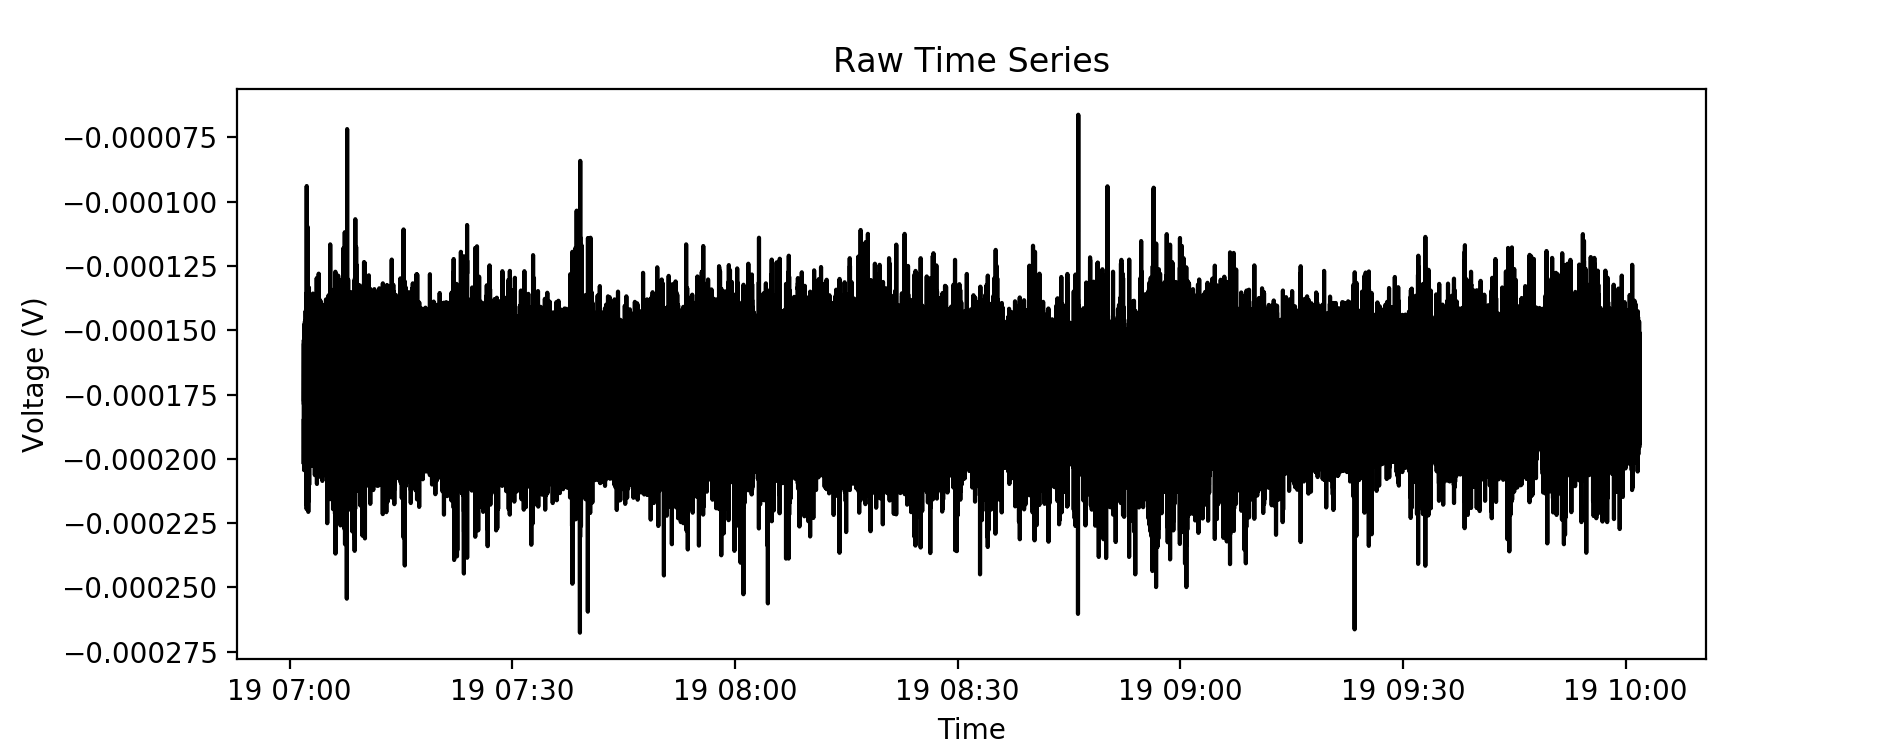

Text(0, 0.5, 'Voltage (V)')

In [6]:
# plot entire time series

plot_time = pd.to_datetime(neural_ts.timestamp, unit='s')

fig, ax = plt.subplots()
ax.plot(plot_time,neural_ts['channel.0'], color='Black')
plt.title('Raw Time Series')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')

We will replot and zoom in to a smaller time interval to better visualize data gaps.

<IPython.core.display.Javascript object>


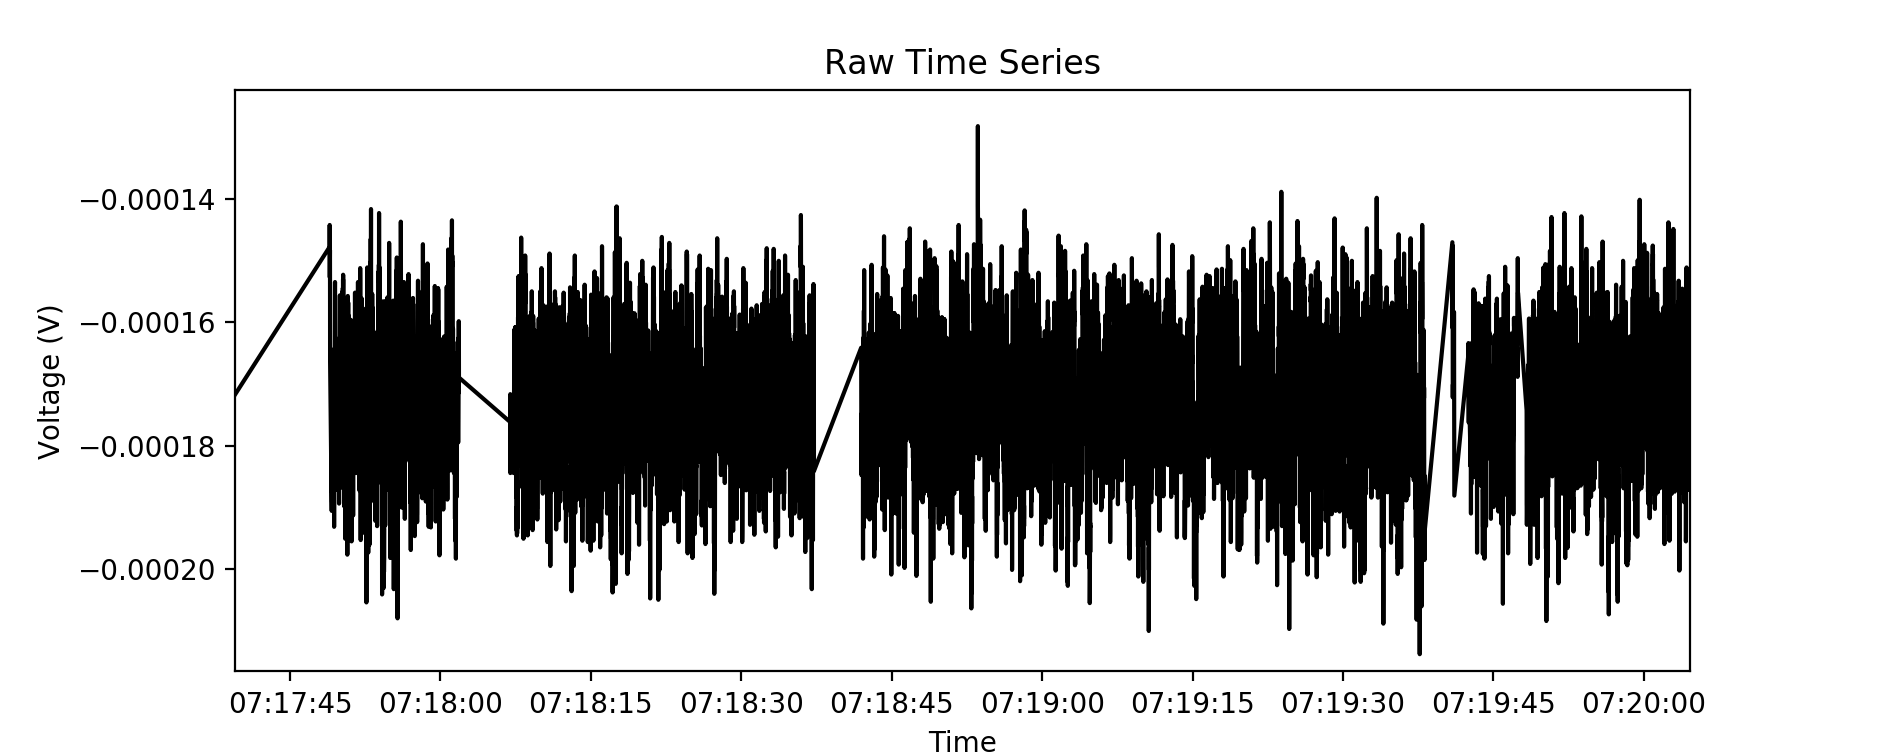

Text(0, 0.5, 'Voltage (V)')

In [7]:
# zoom into time series

fig, ax = plt.subplots()
ax.plot(plot_time,neural_ts['channel.0'], color='Black')
plt.title('Raw Time Series')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')

In [8]:
# set up client

cfg = Config('/Users/witney/Documents/api_config/rcs07_config.yaml')
client = stream.V1Client(cfg)

In [9]:
# duration of gaps that we will tolerate and the minimum duration of an epoch

max_gap = 0.5           # time in sec
min_duration = 10       # time in sec

In [10]:
# initialize parameters for API calls

params = {
    'device_id': 'NPC700403H',
    'start_time': neural_ts.timestamp.iloc[0],
    'end_time': neural_ts.timestamp.iloc[-1],
    'timestamp': 'unix',
}

In [11]:
# check sampling rate of time series

fs = check_sampling_rate(client, params)

Sampling rate: 250


In [12]:
# find epochs without gaps

epochs = check_gaps(neural_ts, fs, max_gap)

In [13]:
# find epochs that meet duration requirements

epochs = check_duration(epochs, min_duration)

In [14]:
# change unix time stamps to datetime for plotting

epochs_dt = []
for epoch in epochs:
    epochs_dt.append(pd.to_datetime(epoch, unit='s'))

<IPython.core.display.Javascript object>


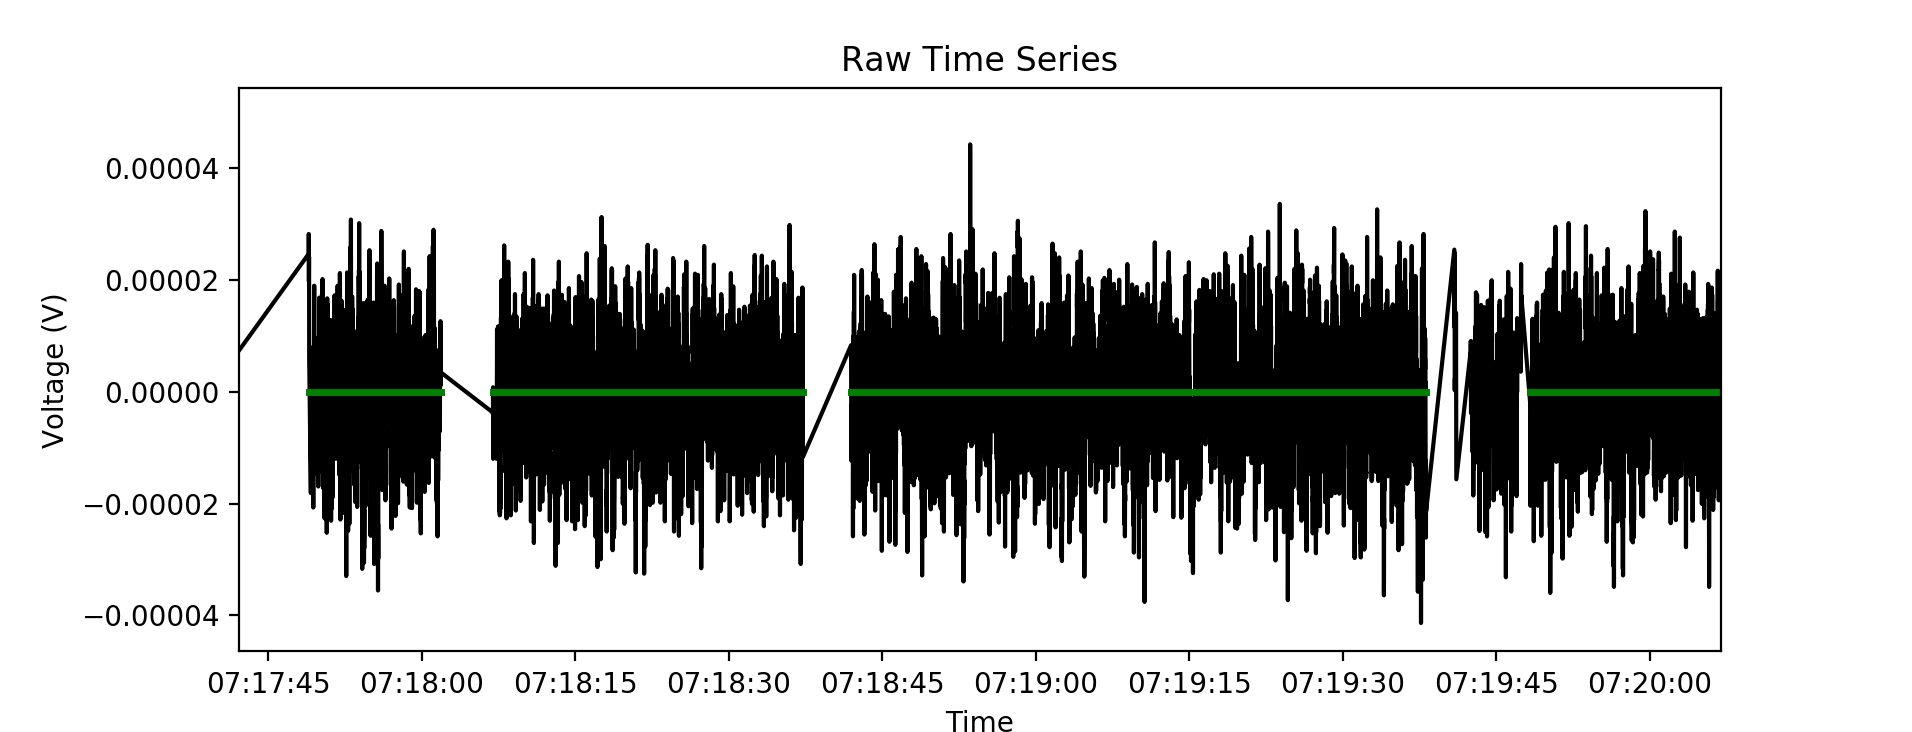

Text(0, 0.5, 'Voltage (V)')

In [15]:
# plot epochs that meet gap and duration requirements

fig, ax = plt.subplots()
ax.plot(plot_time,neural_ts['channel.0']-np.mean(neural_ts['channel.0']),zorder=1, color='Black')
for epoch in epochs_dt:
    ax.plot([epoch[0],epoch[1]], np.zeros(2), zorder=2,color='Green', linewidth=2.5)
plt.title('Raw Time Series')
plt.xlabel('Time')
plt.ylabel('Voltage (V)')

In this plot, the green line marks epochs that meet gap and duration requirements.

## Summary
For neural time series data, we filtered for epochs with gaps that fall under a certain max gap length, and we filtered for epochs that are at least a minimum duration. The same functions can be applied for finding gaps in other time series, such as accelerometry.